In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pickle
import random
import numpy as np
import pandas as pd
import networkx as nx
from fa2 import ForceAtlas2

import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as mpatches

pd.options.mode.chained_assignment = None

# Importing & Preparing Data

In [2]:
PATH = 'data/co-authorship-network/'

In [3]:
edges = pd.read_table(PATH + '/edges.txt', sep=',', header=None)
edges.columns = ["source", "target"]
edges_original = edges.copy()

In [4]:
# Construct graph from edgelist & truncate the graph and cat_df
cat_df = pd.read_csv("Categorical_DF_majority_discipline.csv").set_index('Node ID')
G = nx.from_pandas_edgelist(edges)
G = G.subgraph(cat_df.index)

In [5]:
for node_id, discipline in cat_df['Discipline'].iteritems():
    G.nodes[node_id]['Discipline'] = discipline

# Finding Subgraphs with Community Structure

In [6]:
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
def save_graph_image(G, clusters, cat_df, filename):
    fig, ax = plt.subplots(figsize=(20, 20))
    draw_graph(G)
    plt.savefig(filename, dpi=300)
    plt.close(fig)

def draw_cat_distribution(G, cat_df=cat_df):
    cat_df_subset = cat_df[cat_df.index.isin(G.nodes)]
    cat_df_subset.Discipline = cat_df_subset.Discipline.cat.remove_unused_categories()
    cat_df_subset['Discipline'].value_counts().plot(kind='bar');

In [21]:
def draw_graph_spring(G, cat_df=cat_df):
    # Get the values of the category
    cat_values = cat_df[cat_df.index.isin(G.nodes)]['Discipline'].unique()
    colors = [plt.cm.Set2(i/float(len(cat_values)-1)) for i in range(len(cat_values))]

    # Create a dictionary mapping category values to colors & map nodes to colors
    value_to_color = dict(zip(cat_values, colors))
    node_colors = [value_to_color[cat_df.loc[n]['Discipline']] for n in G.nodes()]

    # Calculate the layout positions using the spring layout
    positions = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(15, 15))
    nx.draw(G, pos=positions, node_size=25, node_color=node_colors)

    # Create a patch for each category value
    patches = [plt.plot([],[], marker="o", color=colors[i], 
               label="{}".format(cat_values[i]))[0] for i in range(len(cat_values))]

    # Add legend
    plt.legend(handles=patches)

In [22]:
def get_connected_subset(G, num_nodes, discipline1='Computer Science', discipline2='Biology'):
    # Filter nodes by discipline
    nodes_discipline1 = [node for node, attr in G.nodes(data=True) if attr['Discipline'] == discipline1]
    nodes_discipline2 = [node for node, attr in G.nodes(data=True) if attr['Discipline'] == discipline2]

    # Calculate the number of nodes for each discipline
    num_nodes_discipline1 = num_nodes // 2
    num_nodes_discipline2 = num_nodes - num_nodes_discipline1

    # Get connected components for each discipline
    connected_components_discipline1 = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_discipline1))]
    connected_components_discipline2 = [G.subgraph(c).copy() for c in nx.connected_components(G.subgraph(nodes_discipline2))]

    # Sort connected components by size
    connected_components_discipline1.sort(key=len, reverse=True)
    connected_components_discipline2.sort(key=len, reverse=True)

    # Select the largest connected components for each discipline
    largest_cc_discipline1 = connected_components_discipline1[0]
    largest_cc_discipline2 = connected_components_discipline2[0]

    # Select the top nodes with the highest degree within the same discipline in the largest connected components
    selected_nodes_discipline1 = sorted(largest_cc_discipline1.nodes, key=lambda node: G.degree(node), reverse=True)[:num_nodes_discipline1]
    selected_nodes_discipline2 = sorted(largest_cc_discipline2.nodes, key=lambda node: G.degree(node), reverse=True)[:num_nodes_discipline2]

    # Create a subgraph with the selected nodes
    selected_nodes = selected_nodes_discipline1 + selected_nodes_discipline2
    subset_graph = G.subgraph(selected_nodes)
    subset_graph = subset_graph.subgraph(max(nx.connected_components(subset_graph), key=len))

    return subset_graph

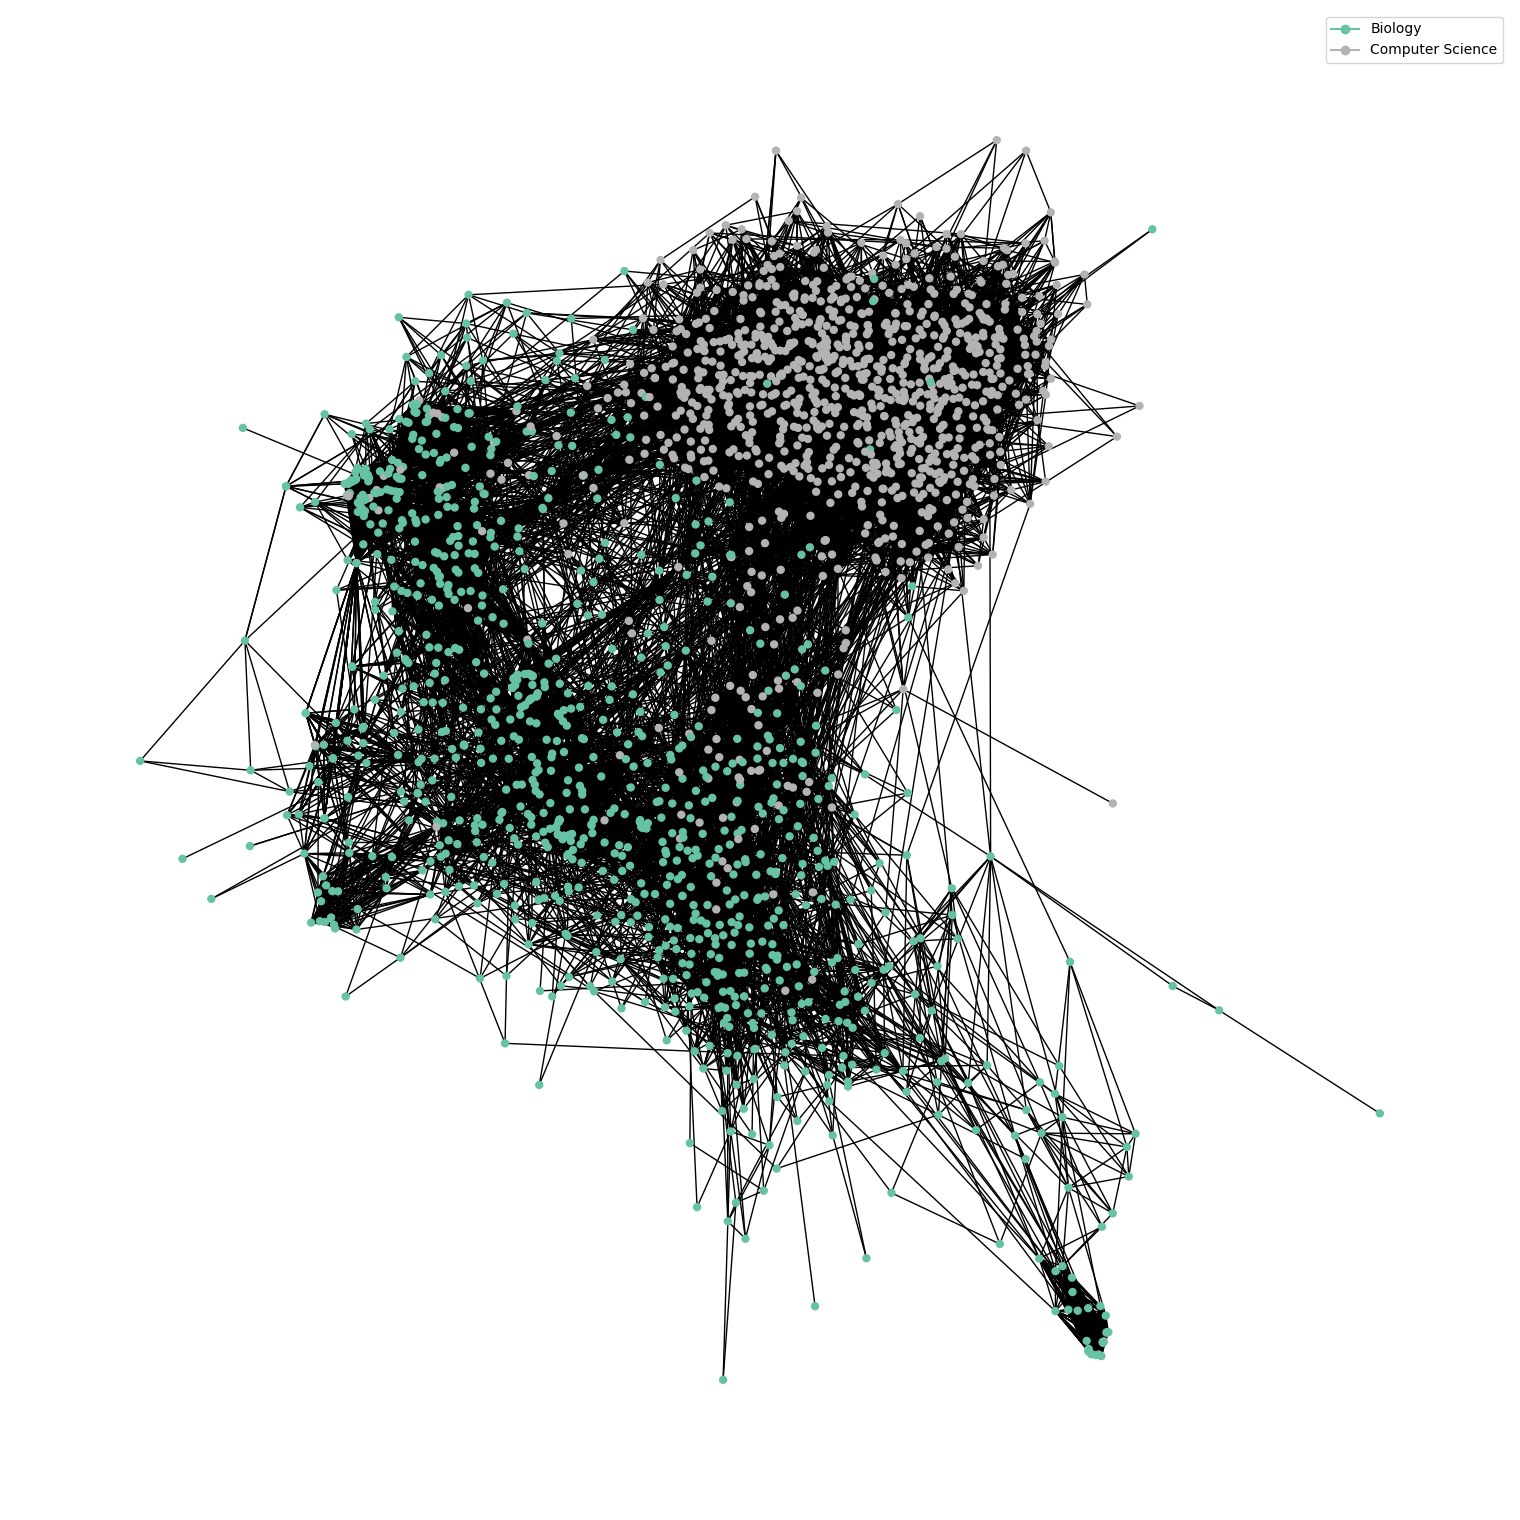

In [23]:
G_subset = get_connected_subset(G, 2000)
draw_graph_spring(G_subset)

# Plotting in-group degree vs. out-group degrees

In [13]:
def get_node_degrees(node, graph, group0, group1):
    connections0, connections1 = 0, 0
    for neighbor in graph.neighbors(node):
        if neighbor in group0:
            connections0 += 1
        elif neighbor in group1:
            connections1 += 1
    return connections0, connections1

In [14]:
def plot_group_degrees(G_cc):
    # Get the category DataFrame for the connected component
    cat_df_cc = cat_df[cat_df.index.isin(G_cc.nodes())]

    # Get the unique category values
    cat_values = cat_df_cc['Discipline'].unique()

    # Separate nodes in the connected component into groups based on their Discipline value
    nodes_groups = {value: [n for n in G_cc.nodes() if cat_df_cc.loc[n]['Discipline'] == value] for value in cat_values}

    # Filter nodes_groups to exclude categories with no nodes
    nodes_groups_filtered = {value: nodes for value, nodes in nodes_groups.items() if len(nodes) > 0}
    filtered_cat_values = list(nodes_groups_filtered.keys())

    # Calculate in-group and out-group degrees for each group with nodes
    group_degrees = {}
    for value, nodes in nodes_groups_filtered.items():
        in_group_degrees, out_group_degrees = [], []
        for node in nodes:
            other_groups = [nodes_groups_filtered[other_value] for other_value in filtered_cat_values if other_value != value]
            other_nodes = [item for sublist in other_groups for item in sublist]
            connections_in_group, connections_out_group = get_node_degrees(node, G_cc, nodes, other_nodes)
            in_group_degrees.append(connections_in_group)
            out_group_degrees.append(connections_out_group)
        group_degrees[value] = (in_group_degrees, out_group_degrees)

    # Plot histograms of in-group and out-group degrees for groups with nodes
    fig, axs = plt.subplots(len(filtered_cat_values), 2, figsize=(10, 5 * len(filtered_cat_values)))
    max_bin_width = 1

    for i, value in enumerate(filtered_cat_values):
        # Calculate the range of in-group and out-group degrees
        in_group_range = np.ptp(group_degrees[value][0])
        out_group_range = np.ptp(group_degrees[value][1])

        # Calculate the number of bins, making sure the bin width doesn't go below max_bin_width
        in_group_bins = max(int(in_group_range / max_bin_width), 1)
        out_group_bins = max(int(out_group_range / max_bin_width), 1)

        # In-group degree histogram for the current group
        axs[i, 0].hist(group_degrees[value][0], bins=in_group_bins, density=True)
        axs[i, 0].set_xlabel('In-group degree')
        axs[i, 0].set_ylabel('Proportion of nodes')
        axs[i, 0].set_title(f'In-group Degree Histogram for {value}')
    
        # Out-group degree histogram for the current group
        axs[i, 1].hist(group_degrees[value][1], bins=out_group_bins, density=True)
        axs[i, 1].set_xlabel('Out-group degree')
        axs[i, 1].set_ylabel('Proportion of nodes')
        axs[i, 1].set_title(f'Out-group Degree Histogram for {value}')

    plt.subplots_adjust(top=0.9, hspace=0.4)

In [19]:
# plot_group_degrees(G_subset)